# Solution

We now arrive at a matrix equation for the unknows $u_i$, which is mearly a system of equations as we've spoken about beforehand.

### Linear PDE

If the PDE is linear, we can solve it with a linear solver which is sparse due to the small support requirement of the elements. The matrix will not in general be banded however, due to the irregular conectivity of the mesh verticies.

#### Example: 1D heat equation

Solve the 1D heat balance equation with $\lambda = 1$ for $x$ from 0 to 10 subject to $J(0)$ = 1 and $T(10) = 0$. Initial condition is $T(x,t=0) = 0$.

The mass matrix is:
$$M_{ij} = \int_{x_1}^{x_2} \phi_i(x) \phi_j(x) dx$$

with

$$\begin{align}
\phi_1(x) &= \frac{x_2-x}{x_2-x_1} \\
\phi_2(x) &= \frac{x-x_1}{x_2-x_1} \\
\end{align}$$

we (Mathematica) get:
$$
M = \frac{[x_2-x_1]}{6} \begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$$

The stiffness matrix needs
$$\begin{align}
\nabla \phi_1(x) &= \frac{-1}{x_2-x_1} \\
\nabla \phi_2(x) &= \frac{1}{x_2-x_1} \\
\end{align}$$

and
$$ \begin{align}
K_{ij} &= \lambda \int_{x_1}^{x_2} \nabla \phi_i(x) \nabla \phi_j(x) dx\\
 &= \frac{\lambda}{h} \begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
\end{align}$$

These *blocks* belong to each element, so we have to build the full matrix by *summing them*. Note this implies an overlap at common verticies between elements!

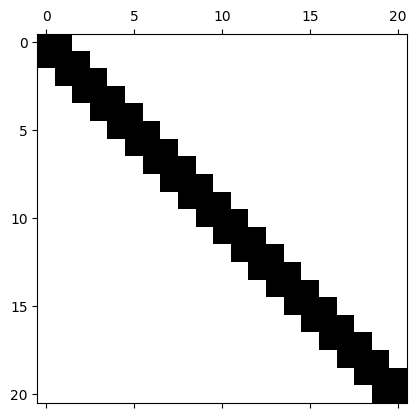

interactive(children=(FloatSlider(value=0.0, description='Final Time:', step=1.0), Output()), _dom_classes=('w…

In [3]:
# prompt: Assemble a a linear system for the heat equation above using the finite element method with Lagrange order 1 elements, using implicit Euler time stepping and a mesh resolution that is concentrated near the left boundary.

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from ipywidgets import interact, FloatSlider

# Define the domain and parameters
L = 10.0  # Length of the domain
n_elements = 20  # Number of elements
dt = 0.1  # Time step
t_final = 1.0  # Final time

# Create a mesh with concentration near the left boundary
x_nodes = np.concatenate((np.linspace(0, 2, int(n_elements / 2) + 1),
                          np.linspace(2 + (L - 2) / (n_elements / 2 - 1), L, int(n_elements / 2))))

# Define the element stiffness and mass matrices for linear elements
def element_stiffness(x1, x2):
    return np.array([[1, -1], [-1, 1]]) / (x2 - x1)

def element_mass(x1, x2):
    return np.array([[2, 1], [1, 2]]) * (x2 - x1) / 6

# Assemble the global stiffness and mass matrices
K = np.zeros((len(x_nodes), len(x_nodes)))
M = np.zeros((len(x_nodes), len(x_nodes)))

for i in range(len(x_nodes) - 1):
    x1 = x_nodes[i]
    x2 = x_nodes[i + 1]
    Ke = element_stiffness(x1, x2)
    Me = element_mass(x1, x2)
    K[i:i + 2, i:i + 2] += Ke
    M[i:i + 2, i:i + 2] += Me

plt.spy(M)
plt.show()

# Apply boundary conditions
# Dirichlet BC at x = L (T(L) = 0)
K[-1, :] = 0
K[-1, -1] = 1
M[-1, :] = 0
M[-1, -1] = 1

# Neumann BC at x = 0 (J(0) = 1)
# We'll implement this in the right-hand side vector later.

# Function to solve and plot for a given time
def solve_and_plot(t_final):
    T = np.zeros(len(x_nodes))
    t = 0.0
    while t < t_final:
        b = M @ T
        b[0] += dt * 1
        T = np.linalg.solve(M + dt * K, b)
        t += dt

    plt.plot(x_nodes, T)
    plt.xlabel('x')
    plt.ylim(-.5, 10)  # Set the y-axis limits to [0, 1]
    plt.ylabel('Temperature')
    plt.title('Temperature Profile at t = {}'.format(t_final))
    plt.show()


# Create a slider for the final time
time_slider = FloatSlider(value=0.0, min=0.0, max=100.0, step=1, description='Final Time:')

# Use interact to link the slider to the function
interact(solve_and_plot, t_final=time_slider);


Note that we built the $M$ and $K$ matricies once, outside the time loop and reuse them for each time step! Even if we had adaptive time stepping, the matrix wouldn't change!

### Nonlinear case

If the PDE is nonlinear, we simply have to use a root finder. Note that in this case we are looking for the parameters $u_i$ directly - the shape functions are unaffected and therefore only the coefficients of the matrix *blocks* are altered. This brings up the concept of *sparsity patterns* which can help reduce the overhead of sparse matrix representaitons.

Since modern finite element software needs to construct the weak form, it is usually equiped with symbolic logic capabilities and therefore able to calculate the Jacobian for use in the root finding algorithm.

#### Example: 1D nonlinear heat equation

Repeat the above exercise with $\lambda = 1 + u/10$

In [6]:
# prompt: Solve the heat transport problem again but this time with \lambda = 1+T/10

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from ipywidgets import interact, FloatSlider

# Define the domain and parameters
L = 10.0  # Length of the domain
n_elements = 20  # Number of elements
dt = 0.1  # Time step
t_final = 1.0  # Final time

# Create a mesh with concentration near the left boundary
x_nodes = np.concatenate((np.linspace(0, 2, int(n_elements / 2) + 1),
                          np.linspace(2 + (L - 2) / (n_elements / 2 - 1), L, int(n_elements / 2))))

# Define the element stiffness and mass matrices for linear elements
def element_stiffness(x1, x2, T):
    lambda_val = 1 + T / 10
    return np.array([[1, -1], [-1, 1]]) * lambda_val / (x2 - x1)


def element_mass(x1, x2):
    return np.array([[2, 1], [1, 2]]) * (x2 - x1) / 6

# Assemble the global stiffness and mass matrices
def assemble_matrices(T):
    K = np.zeros((len(x_nodes), len(x_nodes)))
    M = np.zeros((len(x_nodes), len(x_nodes)))

    for i in range(len(x_nodes) - 1):
        x1 = x_nodes[i]
        x2 = x_nodes[i + 1]
        Ke = element_stiffness(x1, x2, T[i:i+2].mean())
        Me = element_mass(x1, x2)
        K[i:i + 2, i:i + 2] += Ke
        M[i:i + 2, i:i + 2] += Me

    return K, M


# Apply boundary conditions
def apply_boundary_conditions(K, M):
    # Dirichlet BC at x = L (T(L) = 0)
    K[-1, :] = 0
    K[-1, -1] = 1
    M[-1, :] = 0
    M[-1, -1] = 1
    return K, M

# Function to solve and plot for a given time
def solve_and_plot(t_final):
    T = np.zeros(len(x_nodes))
    t = 0.0
    while t < t_final:
        K, M = assemble_matrices(T)
        K, M = apply_boundary_conditions(K, M)
        b = M @ T
        b[0] += dt * 1
        T = np.linalg.solve(M + dt * K, b)
        t += dt

    plt.plot(x_nodes, T)
    plt.xlabel('x')
    plt.ylim(-.5, 10)  # Set the y-axis limits to [0, 1]
    plt.ylabel('Temperature')
    plt.title('Temperature Profile at t = {}'.format(t_final))
    plt.show()


# Create a slider for the final time
time_slider = FloatSlider(value=0.0, min=0.0, max=100.0, step=1, description='Final Time:')

# Use interact to link the slider to the function
interact(solve_and_plot, t_final=time_slider);

interactive(children=(FloatSlider(value=0.0, description='Final Time:', step=1.0), Output()), _dom_classes=('w…

Hmmmm... something is funny in that code!

In [5]:
# prompt: Solve the heat transport problem again but this time with \lambda = 1+T/10 using a root finder

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.optimize import root
from ipywidgets import interact, FloatSlider


# Define the domain and parameters
L = 10.0  # Length of the domain
n_elements = 20  # Number of elements
dt = 0.1  # Time step
t_final = 1.0  # Final time

# Create a mesh with concentration near the left boundary
x_nodes = np.concatenate((np.linspace(0, 2, int(n_elements / 2) + 1),
                          np.linspace(2 + (L - 2) / (n_elements / 2 - 1), L, int(n_elements / 2))))

# Define the element stiffness and mass matrices for linear elements
def element_stiffness(x1, x2, lambda_val):
    return np.array([[1, -1], [-1, 1]]) * lambda_val / (x2 - x1)

def element_mass(x1, x2):
    return np.array([[2, 1], [1, 2]]) * (x2 - x1) / 6

# Assemble the global stiffness and mass matrices
M = np.zeros((len(x_nodes), len(x_nodes)))

for i in range(len(x_nodes) - 1):
    x1 = x_nodes[i]
    x2 = x_nodes[i + 1]
    Me = element_mass(x1, x2)
    M[i:i + 2, i:i + 2] += Me

# Apply boundary conditions
# Dirichlet BC at x = L (T(L) = 0)
M[-1, :] = 0
M[-1, -1] = 1

# Neumann BC at x = 0 (J(0) = 1)
# We'll implement this in the right-hand side vector later.

# Function to solve for T at the next time step using a root finder
def solve_for_next_T(T_prev):
    def residual(T):
        K = np.zeros((len(x_nodes), len(x_nodes)))
        for i in range(len(x_nodes) - 1):
            x1 = x_nodes[i]
            x2 = x_nodes[i + 1]
            lambda_val = 1 + T[i] / 10  # Update lambda based on T
            Ke = element_stiffness(x1, x2, lambda_val)
            K[i:i + 2, i:i + 2] += Ke

        b = M @ T_prev
        b[0] += dt * 1
        b[-1] = 0
        return (M @ T) + dt * (K @ T) - b

    sol = root(residual, T_prev)
    return sol.x

# Function to solve and plot for a given time
def solve_and_plot(t_final):
    T = np.zeros(len(x_nodes))
    t = 0.0
    while t < t_final:
        T = solve_for_next_T(T)
        t += dt

    plt.plot(x_nodes, T)
    plt.xlabel('x')
    plt.ylim(-.5, 10)
    plt.ylabel('Temperature')
    plt.title('Temperature Profile at t = {}'.format(t_final))
    plt.show()


# Create a slider for the final time
time_slider = FloatSlider(value=0.0, min=0.0, max=100.0, step=1, description='Final Time:')

# Use interact to link the slider to the function
interact(solve_and_plot, t_final=time_slider);

interactive(children=(FloatSlider(value=0.0, description='Final Time:', step=1.0), Output()), _dom_classes=('w…